In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
import random

from scipy.optimize import curve_fit

import matplotlib.ticker as plticker
%matplotlib inline


### Forecasting Random Walks?

* Recall that in a random walk is defined 

 $$
 v_t = v_{t-1} + \epsilon_t,
 $$

* Where $\epsilon_t$ is  white noise
  * Recall that we defined white noise as having:
    * Constant mean 
    * Constant variance
    * Values are independently and identically distributed
    
* A special but  common case is the Gaussian noise

$$
    e \sim \mathcal{N}(\mu, \sigma) 
$$


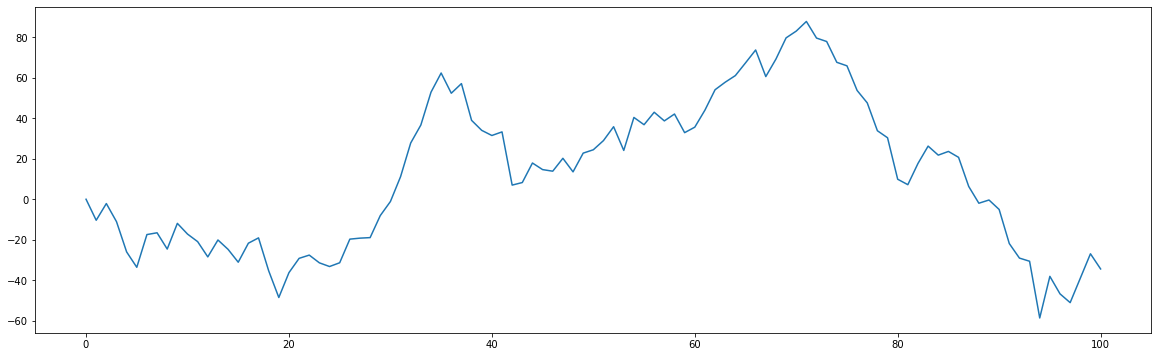

In [2]:
plt.figure(figsize=(20,6))

v = np.zeros(101)
for t in range(1, len(v)):
    v[t] = v[t-1] + 10 *  np.random.normal(0,1)
    
plt.plot(np.arange(101),v)   

### Random Walks and White Noise

* In a random walk, the change in values is merely the white noise


$$
    v_t - v_{t-1}  = \epsilon_t
$$


* We know we cannot predict white noise
  * We don't know the distribution not its parameters
  
* In many cases, the best we can do is assume that the future will be like the immediate past
  * Causal factors will be the same in the short term
  



### Predicting Random Walks -- Cont'd

* The best guess for $v_t$ is $v_{t-1}$

$$
\hat{v}_{t} = v_{t-1}
$$

* This is the "state of the art" for handling data from random walks 
  * Also, called the naïve method or random walk forecasts
    
* Our error is just the noise



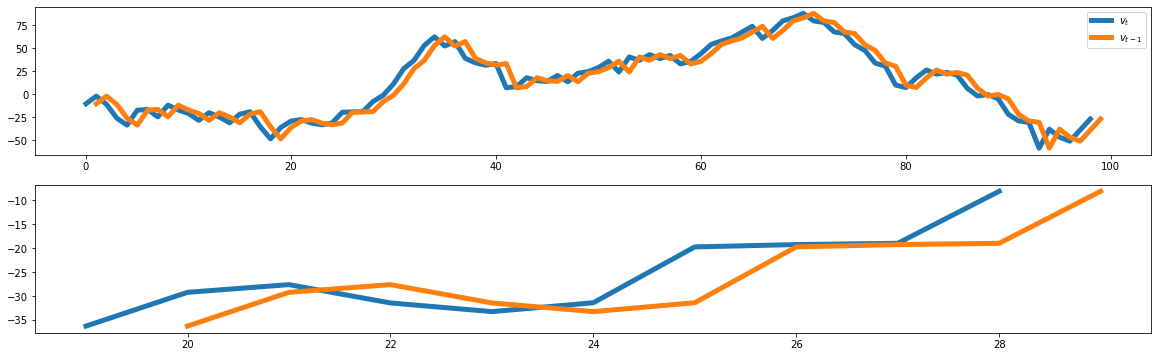

In [3]:
plt.figure(figsize=(20,6))
x_axis = np.arange(0,100)
v_t_subset = v[1:101]
v_tm1_subset = v[0:100]
plt.subplot(2,1,1)
plt.plot(x_axis[:-1], v_t_subset[:-1], label="$v_t$", linewidth=5)
plt.plot(x_axis[1:], v_tm1_subset[1:], label="$v_{t-1}$", linewidth=5)
#plt.fill_between(x_axis, v_tm1_subset, v_t_subset, color='g', alpha=0.5)
plt.legend()
plt.subplot(2,1,2)
plt.plot(x_axis[19:29], v_t_subset[19:29], label="$v_{t-1}$", linewidth=5)
plt.plot(x_axis[20:30], v_tm1_subset[20:30], label="$v_{t}$", linewidth=5)
#plt.fill_between(x_axis, v_tm1_subset, v_t_subset, color='g', alpha=0.5)


### Forecasting Using a Sliding Window

* Noise effect can be additive
  * Multiple sources of noise can be compounded onto the signal
  * E.g., in stock market, noise can be due to political instability, public health news, unforeseen weather events, etc..
  * E.g., IoT sensors can be subject to noise from ambient temperature, interference from external devices, natural interference, etc. 



* In some cases, the effect of some sources of noise can be short-lived
    * Cause major spikes in the data than can bias predictions
    * Time series regresses to its original value after the noise subsides
    
 

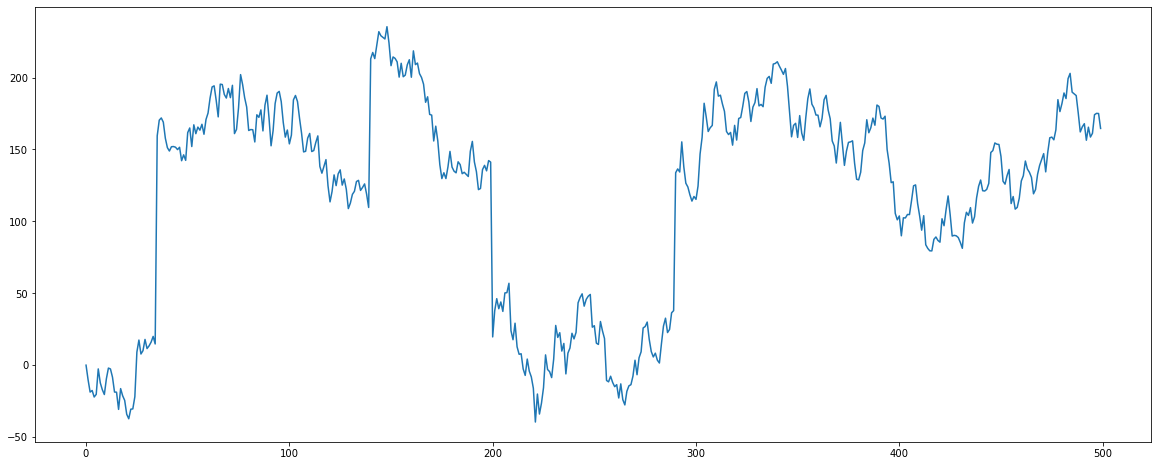

In [4]:
plt.figure(figsize=(20,8))

v = np.zeros(500)
other_noise = 0

for t in range(1, len(v)):
    v[t] = v[t-1] + 10 *  np.random.normal(0,1) - other_noise
    other_noise = 0
    if np.random.binomial(1,0.02):
        noise = np.random.normal(0,100) 
        v[t] +=  noise
    
plt.plot(v)   

### Forecasting Using a Sliding Window

* Outliers can significantly affect the prediction

  <img src="images/outlier.png" alt="drawing" style="width:600px;"/>



### Forecasting Using a Sliding Window - Cont'd


* To know the past, we need to abstract the noise the data, i.e., smooth the data
 
 
* We can smooth th prediction by using the average of "some" $n$ previous values
$$
v_t = \frac{1}{n}\sum_{i=0}^{n-1}v_{t-i}
$$


In [5]:
plt.figure(figsize=(12,6))

random_ts = pd.read_csv("data/rand_ts.csv", header=None, names=['val'])

random_ts

,val
0,-1.0
1,-1.2
2,-1.0
3,-1.2
4,-1.0
...,...
318,2.2
319,2.4
320,2.6
321,2.8


<Figure size 864x432 with 0 Axes>

Text(0.5, 1.0, 'Prediction based on the average of the last 10 values')

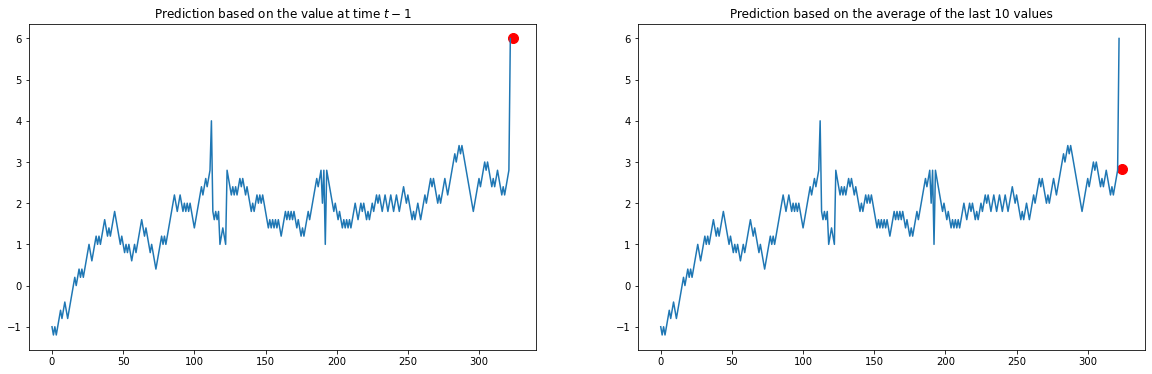

In [6]:
plt.figure(figsize=(20,6))
pred = random_ts[-10:].mean()
plt.subplot(1,2,1)
plt.plot(random_ts)
plt.scatter(len(random_ts)+1, random_ts.val.iloc[-1], color='r', s=100)
plt.title("Prediction based on the value at time $t-1$")
plt.subplot(1,2,2)
plt.plot(random_ts)
plt.scatter(len(random_ts)+1, pred, color='r', s=100)
plt.title("Prediction based on the average of the last 10 values")


### Smoothing data

- This strategy is the same as the one we used for computing the rolling average for the CO2 data

  * Smoothing the curve prior to finding the power law parameter that best fits it
  
    * Recall that we used `scipy.optimize.curve_fit`

* Ideal for subtracting the trend to explore the seasonality

<img src="images/trend.png" alt="drawing" style="width:700px;"/>


### Smoothing Using a Running or Moving Average

* For every value $x_i$, we compute a new smoothed score value $s_i$
  * i.e., compute $x_i$ in light of its neighbors values
  * Uses one the sliding window strategies dicussed before  

* Example 1:
For some window of size $2k+1$, with $k$ a positive value, we compute $s_i$ as: 

$$
s_i = \frac{1}{2k+1} \sum_{j=-k}^{k}x_{i+j}
$$

* Ex. for $k=3$, the window size is $2k+1=7$ and computing the smoothed score $s_{11}$ at position $x_{11}$ amount to averaging the score for positions:

$$
x_{8}, x_{9}, x_{10}, x_{11}, x_{12}, x_{13}, x_{14}
$$

* Example 1:     
For some window of size k, we compute $s_i$ as: 

$$
s_i = \frac{1}{k} \sum_{j=0}^{k}x_{i+j}
$$

* Ex. for $k=4$,  computing the smoothed score $s_{11}$ at position $x_{11}$ amount to averaging the score for positions:

$$
x_{8}, x_{9}, x_{10}, x_{11}
$$

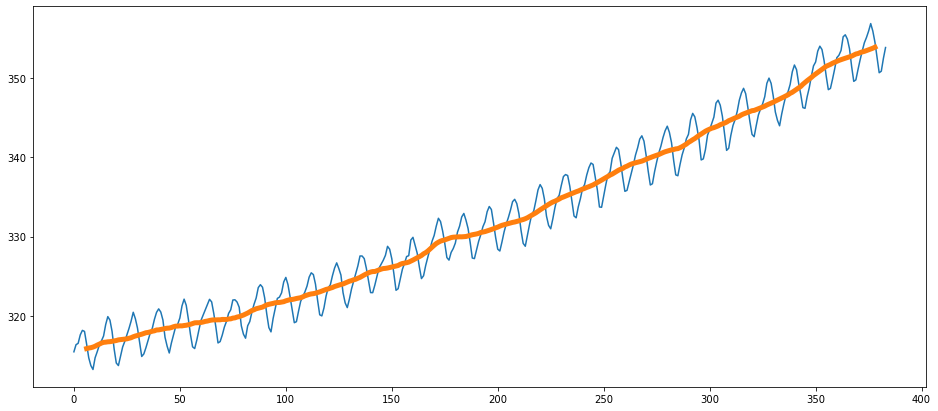

In [7]:
plt.figure(figsize=(16,7))
co2 = pd.read_csv("data/carbon_dioxide.txt", header=None, names=['val'])
plt.plot(co2)
plt.plot(co2.rolling(12, center=True).mean(), linewidth=5)


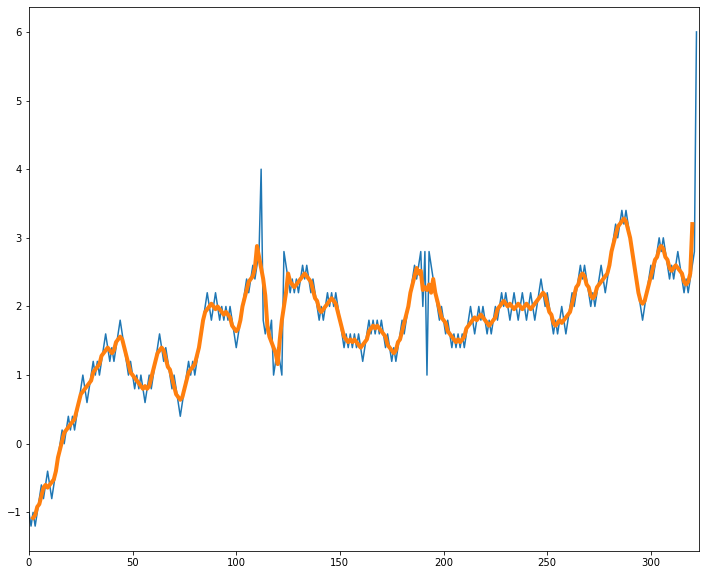

In [8]:
plt.figure(figsize=(12,10))
plt.xlim(0, len(random_ts))
plt.plot(random_ts)

plt.plot(random_ts['val'].rolling(window=5, center=True).mean(), linewidth=4)

### Effect of the Window Size

* The rolling window smooths the data, but the curve is still bumpy around large spikes

* Sudden jumps in the MA value when a relatively large observation (a spike) comes into or falls out of the moving average window.

* We can further smooth the curve by choosing a larger window size
  * More values to dampen the effect of larger values


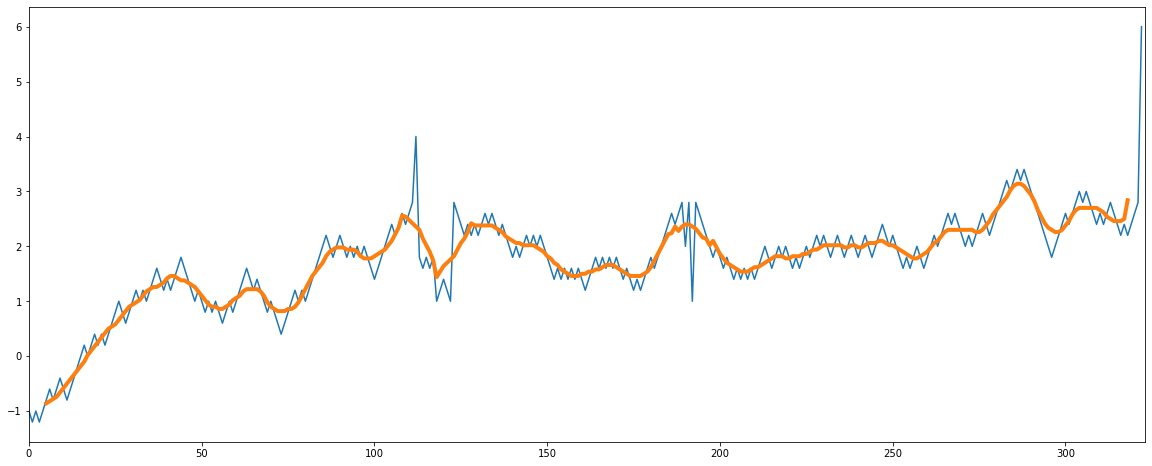

In [9]:
plt.figure(figsize=(20,8))
plt.xlim(0, len(random_ts))
plt.plot(random_ts)
plt.plot(random_ts['val'].rolling(window=10, center=True).mean(), linewidth=4)

### Handling Outliers


* Increasing the window to compensate for few spikes can lead to underfitting the data
  * Overly "flatten" the curve
  * Unduly biases toward sharp, even legitimate increases or decreases
    * Causes a "lag" in the signal
  
 
* Decreasing the window to compensate cna lead to overfitting the data
  * Lose the ability to smooth the data
    * Causes sudden fluctuations that are not reflective of the data



### Handling Outliers

* We can keep a large window size but, for instance, weigh the values in the window differentially

* The points close to window boundaries contribute less than the point in the center 

<img src="https://www.dropbox.com/s/7c4hlmrto5fy9ws/partial_contributions.png?dl=1" />


### Question

* Which approach used a similar strategy for computing the contribution of points differentially across a window?


### Using a Gaussian for Computing the Contributions 

* You can assign the same preset values to specific indices.

* We can use more sophisticated versions that assign custom weights. E.g.,

$ s_i = \sum_{j=-k}^{k}w_{i+j}x_{i+j} $ 

* Where weight $w_i$ for a point $x_i$ can be determined using, for example a Gaussian, such as:
$$
f(\mu_x, \sigma_x) = \frac{1}{\sqrt{2\pi\sigma_x^2}}exp(-\frac{1}{2}(\frac{\mu_x}{\sigma_x})^2)
$$


### Challenges of Using a Gaussian for Computing the Contributions 


* The range of values in each window can vary substantially

* For each window, we need to dynamically scale $\sigma$ so that the likelihoods are not too small



### Challenges of Using a Gaussian for Computing the Contributions  - Cont'd

* Easy to implement but not ideal:

  * The weighted MA can be computationally intensive to evaluate 
    * For each window, we need to determine a specific $\sigma$ and compute the likelihoods for all the points in the window

  * We lose data at the beginning and the end of data due to window constraints
    
* No easy way to incorporate information about the trend or seasonality    





### Exponential Smoothing

* Exponential smoothing mitigates the shortcomings of the rolling window and weighted rolling window

<img src="https://www.dropbox.com/s/rc3zd1q2pjmouyg/previous_contributions.png?dl=1" />



* Intuition: Instead of using simply a subset of the data, we will use all past observations
  
    * The contributions (weights) associated with each point decays exponentially as the observations "get older"


* This simpleconcept is thee basis for some of the most successful forecasting methods.

  * One such power method is exponential smoothing

### Forms of Exponential Smoothing

* Different types of smoothing capture different types of signals

| Type of Smoothing            | Data type                     |
|:------------------------------|:-------------------------------|
| Single Exponential Smoothing | Neither trend nor seasonality |
| Double Exponential Smoothing | Trend but no seasonality      |
| Triple Exponential Smoothing | Trend and seasonality         |


### Single Exponential Smoothing




* Computes smoothed data $s_t$ at time $t$ using the observed value $v_t$ and smoothed value from previous time step ($v_{t-1}$)

$$
s_t = \alpha~v_t + (1-\alpha)~s_{t-1} ~~~~~~\text{where}~~~~~~ 0 \le \alpha \le 1
$$



$s_t$: smoothed value at timestep $t$  
$v_t$: actual unsmoothed value at time step $t$  
$s_{t-1}$: smoothed value at time step $t-1$



### Single Exponential Smoothing: Remarks
  
Note that at:

* $\alpha =0, s_t = (1-\alpha)~s_{t-1}$ we are only retaining the past
* $\alpha =1, s_t = \alpha v_t$ we are only retaining current values

How is this exponential? 

It turns out that:

$$
\begin{align}
s_t &= \alpha~v_t + (1-\alpha)s_{t-1} \\
    &=  \alpha~v_t + (1-\alpha) (\alpha~v_{t-1} + (1-\alpha)s_{t-2})\\
    &=  \alpha~v_t + \alpha(1-\alpha)~v_{t-1} + (1-\alpha)^2s_{t-2}\\    
    &=  \alpha[v_t + (1-\alpha)v_{t-1} + (1-\alpha)^2v_{t-2}+ \ldots + (1-\alpha)^{t-1}v_{1}]+(1-\alpha)^t v_{0}\\
\end{align}
$$


### Single Exponential Smoothing: Remarks -- Cont'd
  

$$
\begin{align}
s_t  &=  \alpha[v_t + (1-\alpha)v_{t-1} + (1-\alpha)^2v_{t-2}+ \ldots + (1-\alpha)^{t-1}v_{1}]+(1-\alpha)^t v_{0}\\
\end{align}
$$

* All the previous values contribute to smoothed value of $x_i$ but their contribution as increasingly small
* The contribution of past values is controlled by the decay of the parameter $\alpha$
  * This geometric progression (geometric series) is the discrete version of an exponential function
    * A geometric sequence is discrete while an exponential function is continuous
      * This is where the name for this smoothing method originated




### Single Exponential Smoothing: Remarks -- Cont'd
  
* Given that we have smoothed our signal, we can use $s_t$ in forecasting

* Our approach is going to be simple

$ F_{t+1} = s_t$ 

* Our data is more resilient to outliers
* The prediction takes into account weighted contributions of previous time points

### Single Exponential Smoothing as a Function of the forecasting error

* Note that the forecast at time $t+1$ ($F_{t+1}$) is similar to the random walk algorithm used earlier

 
$$
\begin{align}
s_t &= \alpha~v_t + (1-\alpha)s_{t-1} \\
    &= \alpha v_t + s_{t-1}-\alpha s_{t-1} \\
    &= s_{t-1} + \alpha (v_t - s_{t-1}) \\
\end{align}
$$

Since
$ F_{t+1} = s_t$,
and
$ F_{t} = s_{t-1}$

then
 
$$
\begin{align}
F_{t+1} &= F_{t} + \alpha (v_t - F_t)\\
F_{t+1} &= F_{t} + \alpha (E)\\
\end{align}
$$

Where epsilon is here the E in forecasting (the difference between forecasted and observed values)

### Single Exponential Smoothing as a Function of the forecasting error - Cont'd

$$
\begin{align}
F_{t+1} = &= F_{t-1} + \alpha (E)\\
\end{align}
$$

* $E$ in forecasting (the difference between forecasted and observed values)
* This means that to forcast $F_{t+1}$ is simply the forecast at $F_T$ padded with a fraction of the error in predicting $F_T$.



### Using Exponential Smoothing with  `Pandas.Series`

* The Series objects has a `ewm` (exponentially weighted method) 

```
> random_ts['val'].ewm(alpha = 0.5)
ExponentialMovingWindow [com=0.5,min_periods=1,adjust=True,ignore_na=False,axis=0,method=single]
```

* Note that single exponential smoothing is simply a complex weighted average

* We compute the new values by using the mean function

```
random_ts['val'].ewm(alpha=0.5).mean()
```




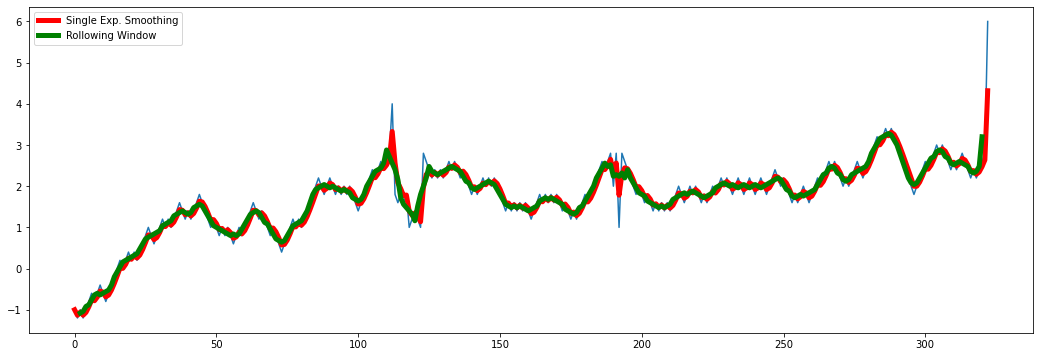

In [31]:
plt.figure(figsize=(18,6))
plt.plot(random_ts)
plt.plot(random_ts['val'].ewm(alpha=0.5).mean(), color='r', lw=5, label="Single Exp. Smoothing")
plt.plot(random_ts['val'].rolling(window=5, center=True).mean(), color='g', lw=5, label="Rollowing Window")
plt.legend()

### Impact of Param $\alpha$

<img src="images/exp_smoothing.png" alt="drawing" style="width:600px;"/>


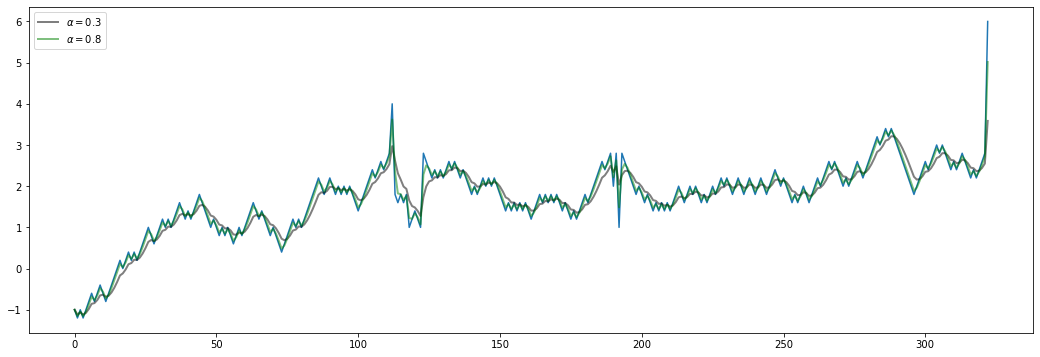

In [37]:
plt.figure(figsize=(18,6))
plt.plot(random_ts)
plt.plot(random_ts['val'].ewm(alpha=0.3).mean(), color='k', lw=2, alpha=0.5, label=r"$\alpha = 0.3$")
plt.plot(random_ts['val'].ewm(alpha=0.7).mean(), color='g', lw=2, alpha=0.5, label=r"$\alpha = 0.8$")
plt.legend()

### Double Exponential Smoothing

* It would unwise to discard the trend information if one exists.

* Double exponential smoothing implicitly accounts for information about the trend
  
   * A "non-parametric equivalent" for identifying the equation that best fits the trend

* We will include the trend in our forecast

$$
S_t = \mbox{S}_{t-1} + \mbox{r}_{t-1},
$$

* Where $r_{t-1}$ is the trend at time ${t-1}$


* $s_t$ is also called the level 





### Accounting for the Trend

<img src="https://www.dropbox.com/s/s0ogfwje0rg81kv/trend.png?dl=1" width=400>

* It helps to think of the trend as the exponentially weighted increases since t=0
  * The most recent inrease gets weight of alpha


### Double Exponential Smoothing - Step 2


<img src="https://www.dropbox.com/s/gnj6o92mm4qp95w/trend_example.png?dl=1" width=500>


* We can infer the trend $r_t$ using the same approach used to compute $s_t$


$$
r_t = \beta(s_{t} - s_{t-1}) + (1-\beta)r_{t-1}
$$

- This equation uses a trend coefficient $\beta$ which acts in a similar as $\alpha$ on signal

  - Recall that the assumption here is that there is no seasonality


### Double Exponential Smoothing: Step 1




$$ 
s_t = \alpha \cdot v_t + (1-\alpha)(s_{t-1} + r_{t-1})
$$



- Similar to the equation used in single exponential smoothing

  - We add the effect of the trend to $s_t$ 



### Double Exponential Smoothing for Forecasting


- The double exponential smoothing can be used in forecasting by using the last smoothed value and adding, at each predicted timestep, the smoothed trend to it.

$$
F_{i+1} = s_i + r_{i}
$$



### Triple Exponential Smoothing

* The assumption here is that there is seasonality in the data
  * We need another "quantity" to capture the seasonality
  * Similar to how we direved a quantity to capture the trend
  
* The idea is to capture seasonality by using the data across past seasons at the same time in the period
  * For instance, in time series with a yearly seasonality, the seasonality components for March would be exponentially smoothed with only data points from March in previous years.


* A non-parametric way to accout for seasonality



### Triple Exponential Smoothing -- Cont'd

The new equation for the triple exponential component is:
$$
    p_t = \gamma(v_t - s_t) + (1-\gamma) p_{t-k}
$$

where:

* $k$: is the period’s length
  * This is a param of the model; cna be derived using ACF or by find the the value that best fits the data.
* $\gamma$: is the new smoothing factor for the seasonal component



### Triple Exponential Smoothing: Remarks

- The concept here is similar to what we have done in the past

- Seasonality component $p_i$ is weighted using the last previous observed point exactly one period, $k$, ago 

* The function for predicting future values is computed as:

$$
F_{t+1} = s_t + r_t + p_t 
$$


### Testing the Explonential Smoothing

* Does the approach pass muster with the CO2 data set we manually investigated

  * The data exhibits clear trend and seasonality

* Here we implement and test our owen version 

  * If you decide to test this with the assignment data, you should use `statsmodel` package 


In [59]:
sum(co2_data["co2_val"][12*0:12*0+12])/float(12)


315.8266666666666

In [65]:
# function that returns the initial value of trend
# \beta_0
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series["co2_val"][i+slen] - series["co2_val"][i]) / slen
    return sum / slen

# function that return the initial value of seasonality
# \gamma_0
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):

        season_averages.append(sum(series["co2_val"][slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series["co2_val"][slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series["co2_val"][0]
            trend = initial_trend(series, slen)
            result.append(series["co2_val"][0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series["co2_val"][i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [66]:
import pandas as pd
co2_data = pd.read_csv("https://www.dropbox.com/s/cegyok4vqmhikey/carbon_dioxide.txt?dl=1", names=["co2_val"])
co2_data.co2_val = co2_data.co2_val.astype('float64')
co2_data.head()

,co2_val
0,315.42
1,316.32
2,316.49
3,317.56
4,318.13


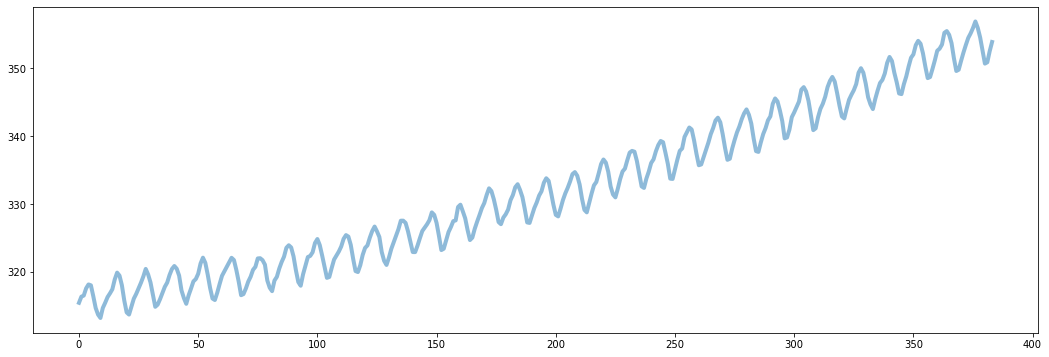

In [67]:
# We use the exponential smoothing to forecast the next 24 months (2 periods)

plt.figure(figsize=(18,6))


#forecast = triple_exponential_smoothing(co2_data, 12, 0.005, 0.2, 0.00001, 24)

# pyplot.plot(forecast, 'r--', lw=4) # the smoothed/predicted data in red

plt.plot(co2_data, alpha=0.5, lw=4) # the true data in blue

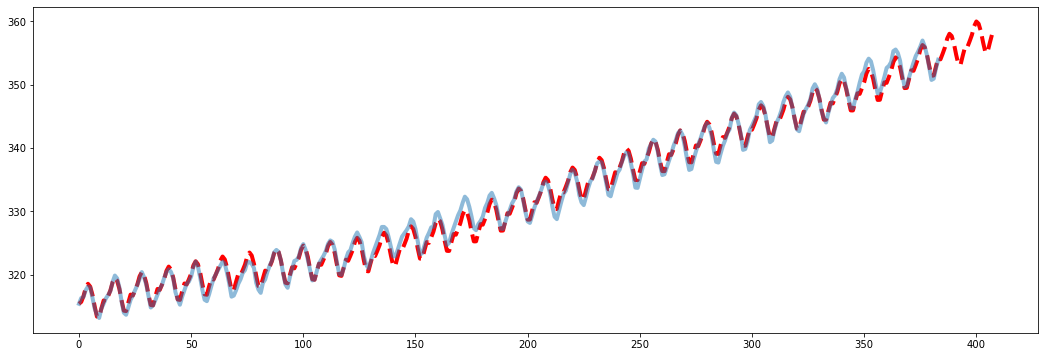

In [69]:
# We use the exponential smoothing to forecast the next 24 months (2 periods)

plt.figure(figsize=(18,6))


forecast = triple_exponential_smoothing(co2_data, 12, 0.005, 0.2, 0.00001, 24)

plt.plot(forecast, 'r--', lw=4) # the smoothed/predicted data in red

plt.plot(co2_data, alpha=0.5, lw=4) # the true data in blue

### Question 

- In your opinion, how did I derive the values for $\alpha$, $\beta$ and $\gamma$?
  - Hint: how did we derive the data for the power law function used to model the trend or the value of $k$ when clustering the time series (assignment 3)?
  